<div style="background-color:#f0f0f0; color:#444; width:80vw; max-width:900px; margin-left:auto; margin-right:auto; border-radius:6px; padding:16px 0; text-align:center; font-weight:bold; font-size:1.5em; box-shadow:0 2px 8px #ccc;">
Accompanist Tempo Detection
</div>
<br>
<div style="text-align:center">
This notebook is for testing tempo detection methods on recordings and in real-time.
</div>
<br>
<div style="font-size:1.5em; font-weight:bold;">Approaches For Tempo Detection</div>

1. ✅ Traditional approach of onset detection (STFT + spectral flux) and then compute tempo from the detected onsets. (***Problem:** seems to be quite sensitive to the parameters used*). Maybe try image processing on the tempogram to get tempo? 
<br><br>
Experiment with downsampling:
```python
        sr = 10000
        signal = librosa.resample(signal, orig_sr=sr, target_sr=sr) # downsample to 10 kHz
        t = np.arange(len(signal))/sr
        sf.write(f'../audio_out/{name}_filtered.wav', signal, sr) # save filtered signal
```
2. Some sort of interpolation between tempos to get more accurate estimates? Or use a weighed average of tempos around the peak?
3. ❌ Window + lowpass filter each frame of the signal to 20-45 Hz (corresponding to common tempo BPMs) and look at the max frequency component. Maybe do this on the onset envelope if it works better. This is the simplest approach but may not be the most effective. 
4. ✅ Similar to decoding an on-off keyed message (i.e. 1 if start of a beat, 0 if not start of a beat). This just involves computing the power of the frequency spectrum of each frame ("bit") and comparing with a threshold. This approach is likely combined with other approaches. 
5. Try wavelet transform instead of stft for onset detection (find power of frequency spectrum of each frame and compute spectral flux). What if each basis function was a wavelet + sin wave?
6. Model the noise of the channel/recording by recording "silence." Amplify the input signal and subtract out the amplified noise to get stronger peaks?
7. ***This one is probably required.*** Build ML model to classify the rhythm of the music based on the estimated tempo and onsets.

---

<div style="font-size:1.5em; font-weight:bold;">Additional Features</div>

1. Maybe have the user clap a few times before to establiish a tempo to "calibrate" the alogrithm. Not sure how useful this is in detecting the tempo of the recording, but it helps with syncing at the start.
2. Support different modes:
    - Solo mode: recording always follows the musician. For general practice.
    - Orchestral mode: musicians can set accompanist to match a conductor (timings are determined from a video of the conductor). For orchestral musician practice.

---

<div style="font-size:1.5em; font-weight:bold;">Currently Implemented Approach</div>

- Load audio signal and remove DC offset
- Set relevant parameters: hop_length = `256 samples`, win_dur = `4 seconds`
- Bandpass filter signal from `[20 Hz, 4 kHz]` to remove noise
- Compute onset envelope using Librosa's onset detection and remove DC offset
- Lowpass filter onset envelope at `10 kHz` and remove any values `< 0.05 * max`
- Compute tempogram using Librosa's tempogram function, get tempo bins, and limit to `[35 BPM, 200 BPM]`
- Extract peaks from tempogram to get tempo candidates
- Generate click track for verification

<div style="font-size:1.5em; font-weight:bold;">Pipeline</div>

Load $\to$ Remove DC $\to$ Bandpass $\to$ Onset Envelope $\to$ Lowpass $\to$ Tempogram $\to$ Tempo Estimates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from scipy.signal import butter, sosfilt, lfilter, hilbert
import os
from math import ceil

In [2]:
#  choose audio file
name = 'metronome_track'
filename = f'{name}.mp3'

In [3]:
# load audio file
audio_path = f'../audio_in/{filename}'
if not os.path.exists(audio_path):
	raise FileNotFoundError(f'Audio file not found: {audio_path}')

signal: np.ndarray
signal, sr = librosa.load(audio_path, sr=None)  
signal -= np.mean(signal) # remove DC offset
t = np.arange(len(signal))/sr # get time vector

print(f'Sample rate: {sr}')
print(f'Signal length: {len(signal)}')
print(f'Signal duration: {len(signal)/sr:.3f} s')

Sample rate: 44100
Signal length: 1285146
Signal duration: 29.142 s


Text(0, 0.5, 'Amplitude')

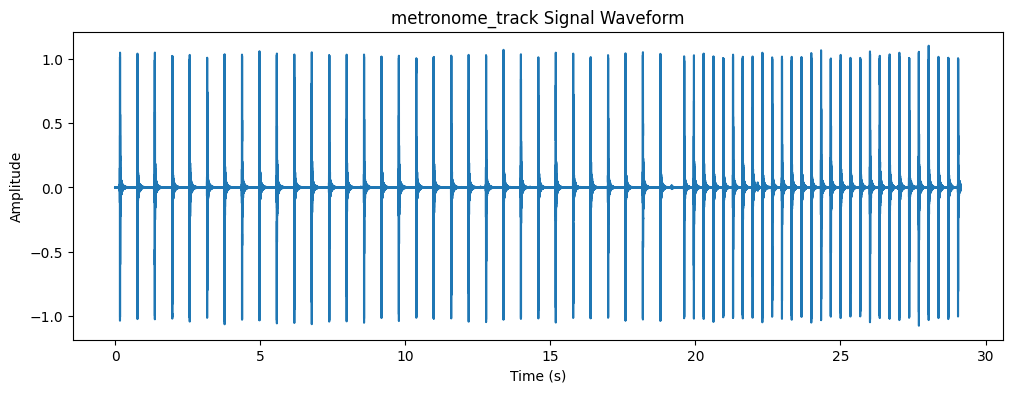

In [4]:
# plot signal waveform
plt.figure(figsize=(12, 4))
plt.plot(t, signal)
plt.title(f'{name} Signal Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

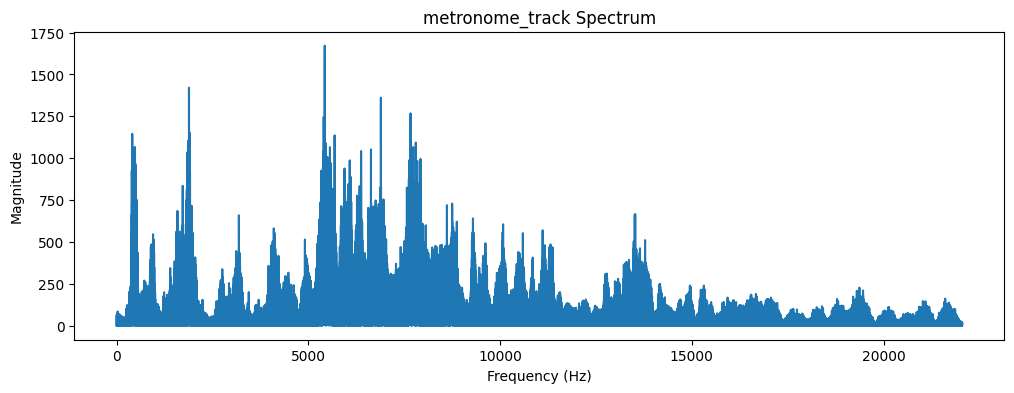

In [5]:
# plot signal spectrum
def plot_spectrum(signal, sr, name, filtered=False):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, d=1/sr)
    fft_vals = np.fft.rfft(signal)
    magnitude = np.abs(fft_vals)

    plt.figure(figsize=(12, 4))
    plt.plot(freqs, magnitude)
    if filtered: plt.title(f'{name} Filtered Spectrum')
    else: plt.title(f'{name} Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')

plot_spectrum(signal, sr, name)

In [6]:
# bandpass filter
def bandpass_filter(signal, sr, lowcut=60, highcut=4000, order=5):
    sos = butter(order, [lowcut, highcut], btype='bandpass', fs=sr, output='sos')
    filtered_signal = sosfilt(sos, signal)
    return filtered_signal

# lowpass filter
def lowpass_filter(signal, sr, cutoff=4000, order=5):
    sos = butter(order, cutoff, btype='lowpass', fs=sr, output='sos')
    filtered_signal = sosfilt(sos, signal)
    return filtered_signal

# highpass filter
def highpass_filter(signal, sr, cutoff=60, order=5):
    sos = butter(order, cutoff, btype='highpass', fs=sr, output='sos')
    filtered_signal = sosfilt(sos, signal)
    return filtered_signal

In [7]:
def apply_fir_filter(signal, window):
    window = np.array(window)
    window /= np.sum(window)
    filtered = np.convolve(signal, window, mode='same')
    return filtered

<div style="background-color:#f0f0f0; color:#444; width:80vw; max-width:900px; margin-left:auto; margin-right:auto; border-radius:6px; padding:16px 0; text-align:center; font-weight:bold; font-size:1.5em; box-shadow:0 2px 8px #ccc;">
Traditional Approach
</div>

In [8]:
# define parameters
hop_length = 256 # distance between frames
win_dur = 2 # window duration in seconds (use 4 for percussive pieces, 2 for classical pieces)

time_res = hop_length/sr # temporal resolution
freq_res = 1/win_dur # frequency resolution
win_length = int((win_dur*sr)/hop_length) # window length in frames
print(f'Temporal resolution: {time_res:.3f} s')
print(f'Frequency resolution: {freq_res:.3f} Hz/bin')
print(f'Window length: {win_length} frames')

pedal_reduce = True
pedal_strength = 0.5

bandpass_high = 4000
bandpass_low = 20
lowpass_cutoff = 10000

tempo_min = 35
tempo_max = 200
alpha = 0.075
plot_tempogram = True

peak_threshold = 0.2

extra_processing = False

Temporal resolution: 0.006 s
Frequency resolution: 0.500 Hz/bin
Window length: 344 frames


In [9]:
def reduce_pedal(y, sr, output_path, strength=0.5, write_file=True):
    analytic_signal = hilbert(y) # envelope detection using hilbert transform
    envelope = np.abs(analytic_signal)

    # create suppression mask
    env_norm = envelope/np.max(envelope)
    inv_env = 1.0-env_norm
    suppression = 1.0-strength*inv_env
    suppressed_y = y*suppression

    output_y = highpass_filter(suppressed_y, sr, cutoff=80, order=4) # highpass to reduce resonance
    
    if write_file: sf.write(output_path, output_y, sr)
    return y, output_y

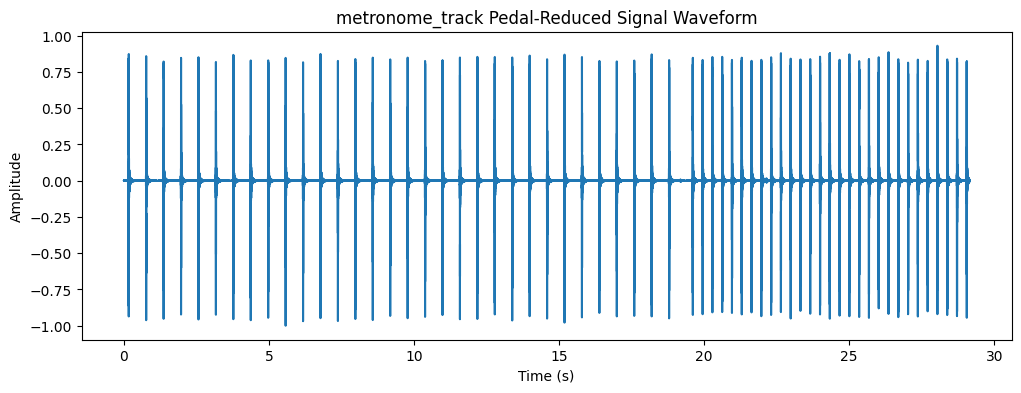

In [10]:

original_signal = None
if pedal_reduce:
    dampened_path = f'../audio_out/partial_renders/{name}_dampened.mp3'
    original_signal, signal = reduce_pedal(signal, sr, dampened_path, strength=pedal_strength)
    signal /= np.max(np.abs(signal))

    plt.figure(figsize=(12, 4))
    plt.plot(t, signal)
    plt.title(f'{name} Pedal-Reduced Signal Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

In [11]:
# bandpass filter original signal
signal = bandpass_filter(signal, sr, lowcut=bandpass_low, highcut=bandpass_high)
signal /= np.max(np.abs(signal)) # normalize

Text(0, 0.5, 'Amplitude')

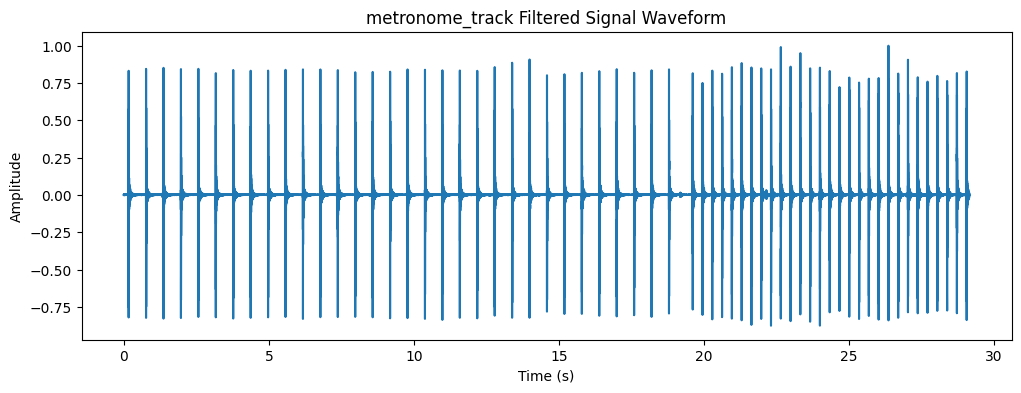

In [12]:
# plot filtered signal
plt.figure(figsize=(12, 4))
plt.plot(t, signal)
plt.title(f'{name} Filtered Signal Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

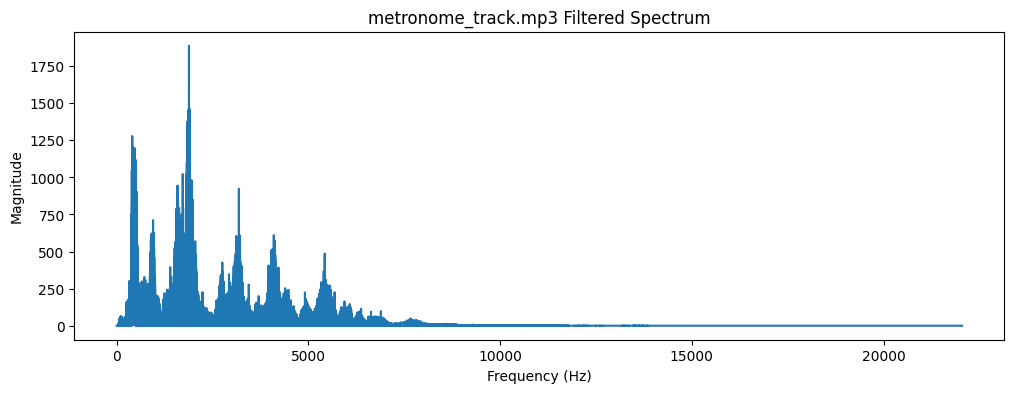

In [13]:
# plot spectrum of filtered signal
plot_spectrum(signal, sr, filename, filtered=True)

In [14]:
# find onset envelope
onset_env = librosa.onset.onset_strength(y=signal, sr=sr, hop_length=hop_length)
onset_env -= np.mean(onset_env)
if np.all(onset_env == 0): 
    raise ValueError('Onset envelope is all zeros. Try a different audio file.')

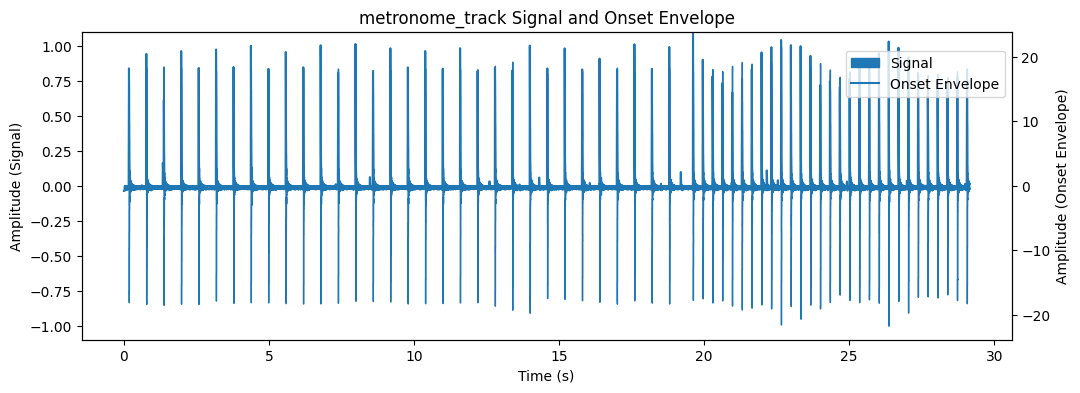

In [15]:
# plot onset envelope overlaid with original signal
fig, ax1 = plt.subplots(figsize=(12, 4))

librosa.display.waveshow(signal, sr=sr, ax=ax1, label='Signal')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (Signal)')
ax1.tick_params(axis='y')

max_onset = np.max(np.abs(onset_env))
ax2 = ax1.twinx()
ax2.plot(np.arange(len(onset_env))*time_res, onset_env, label='Onset Envelope')
ax2.set_ylabel('Amplitude (Onset Envelope)')
ax2.tick_params(axis='y')
ax2.set_ylim(-max_onset, max_onset)

plt.title(f'{name} Signal and Onset Envelope')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85))
plt.show()

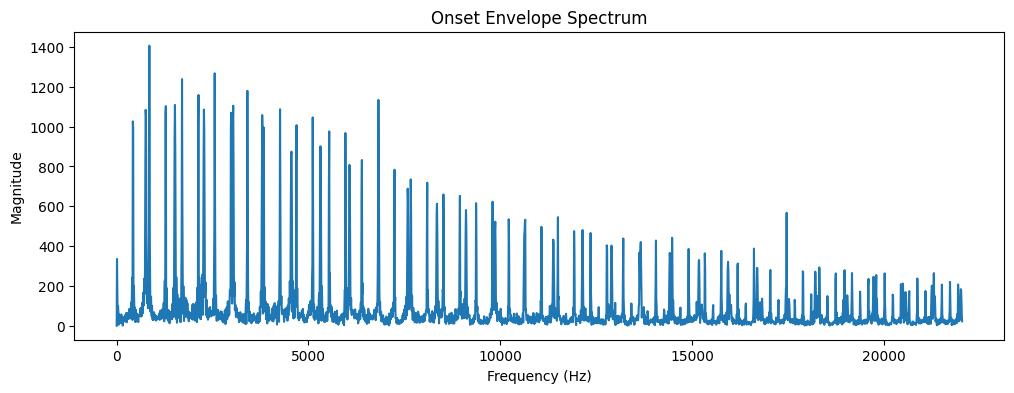

In [16]:
# plot onset envelope spectrum
plot_spectrum(onset_env, sr, 'Onset Envelope')

In [17]:
# filter onset envelope
onset_env = lowpass_filter(onset_env, sr, cutoff=lowpass_cutoff, order=8)

# keep values avove threshold
threshold = alpha*np.max(onset_env)
threshold_idx = np.where(onset_env<threshold)[0]
onset_env[threshold_idx] = 0

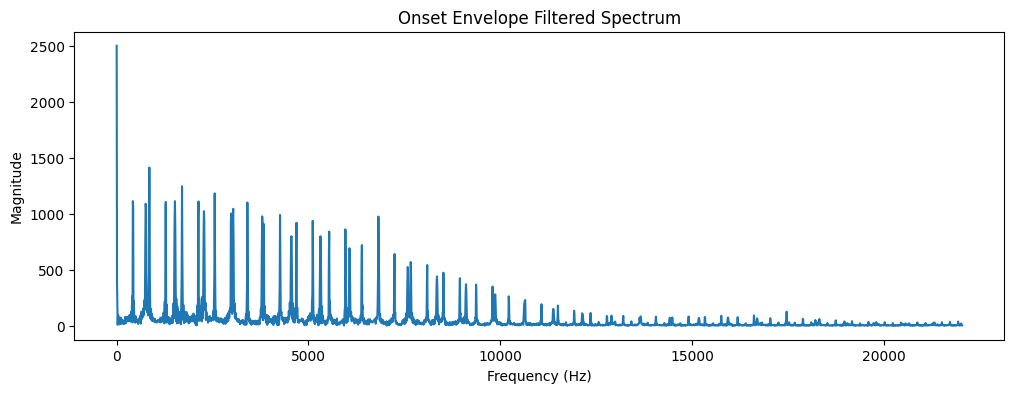

In [18]:
# plot filtered onset envelope spectrum
plot_spectrum(onset_env, sr, 'Onset Envelope', filtered=True)

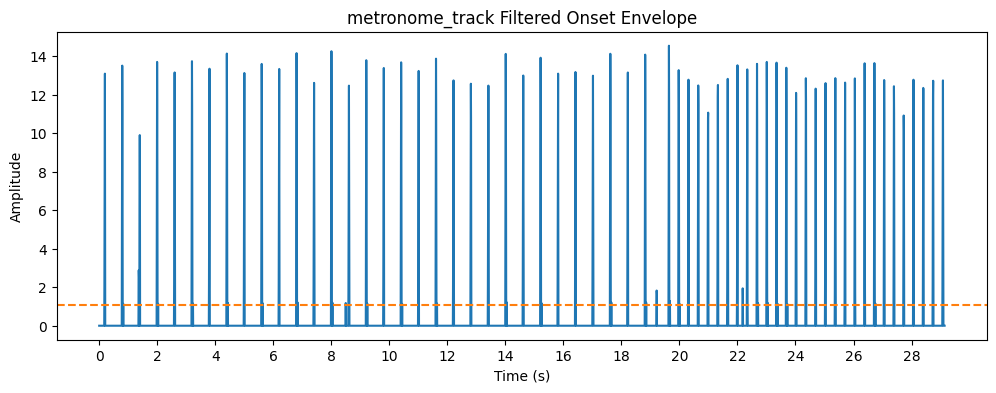

In [19]:
# plot filtered onset envelope
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(onset_env))*time_res, onset_env)
plt.title(f'{name} Filtered Onset Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.axhline(y=threshold, linestyle='--', color='#ff7f0e')
_ = plt.xticks(np.arange(0, len(onset_env)*time_res, 2))

In [20]:
# compute tempogram, skipping first bin
tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=hop_length, win_length=win_length)[1:,:]
tempo_bins = librosa.tempo_frequencies(tempogram.shape[0], sr=sr, hop_length=hop_length)

# for limiting tempo of tempogram
fmin = max(tempo_min, tempo_bins[-1])
fmax = min(tempo_max, tempo_bins[0])

print(f'Max tempo: {fmax:.2f} BPM')
print(f'Min tempo: {fmin:.2f} BPM')
print(f'Number of tempo bins: {len(tempo_bins)}')

Max tempo: 200.00 BPM
Min tempo: 35.00 BPM
Number of tempo bins: 343


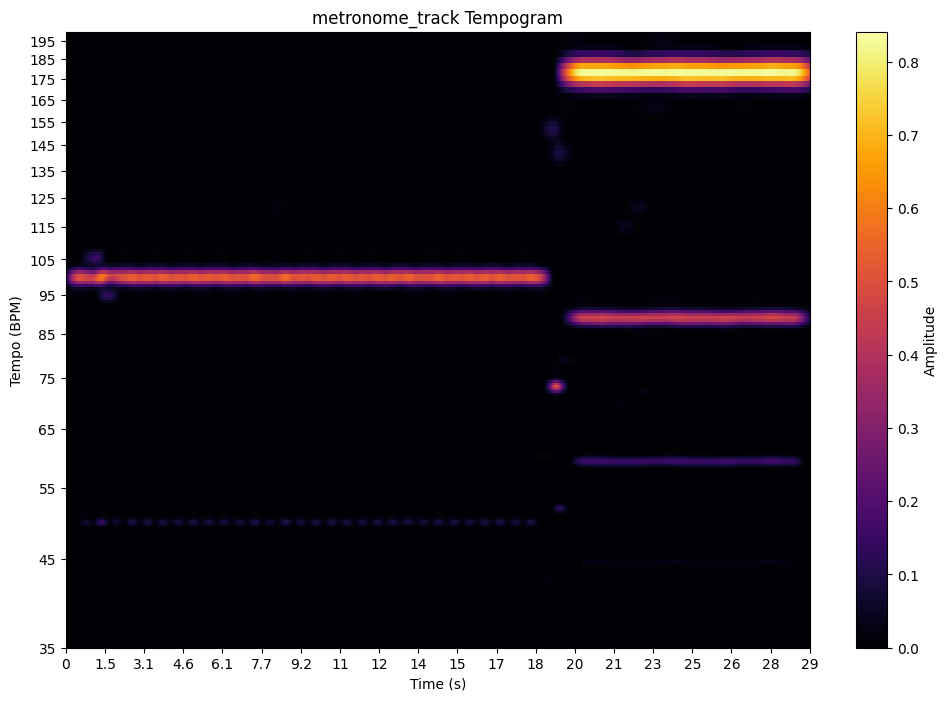

In [21]:
# plot tempogram
if plot_tempogram:
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length, x_axis='time', 
                            y_axis='tempo', cmap='inferno')
    plt.ylim(fmin, fmax) 
    plt.colorbar(label='Amplitude')
    plt.title(f'{name} Tempogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Tempo (BPM)')

    yticks = np.arange(ceil(fmin), ceil(fmax), 10)
    _ = plt.yticks(yticks)
    _ = plt.xticks(np.linspace(0, tempogram.shape[1]*time_res, 20))

Using tempo bins in index range [52, 295]
Using tempo bins in BPM range [35.04 BPM, 198.77 BPM]
Estimated tempos: [  0.           0.           0.         ... 181.27360166 181.27382664
 181.2740566 ]


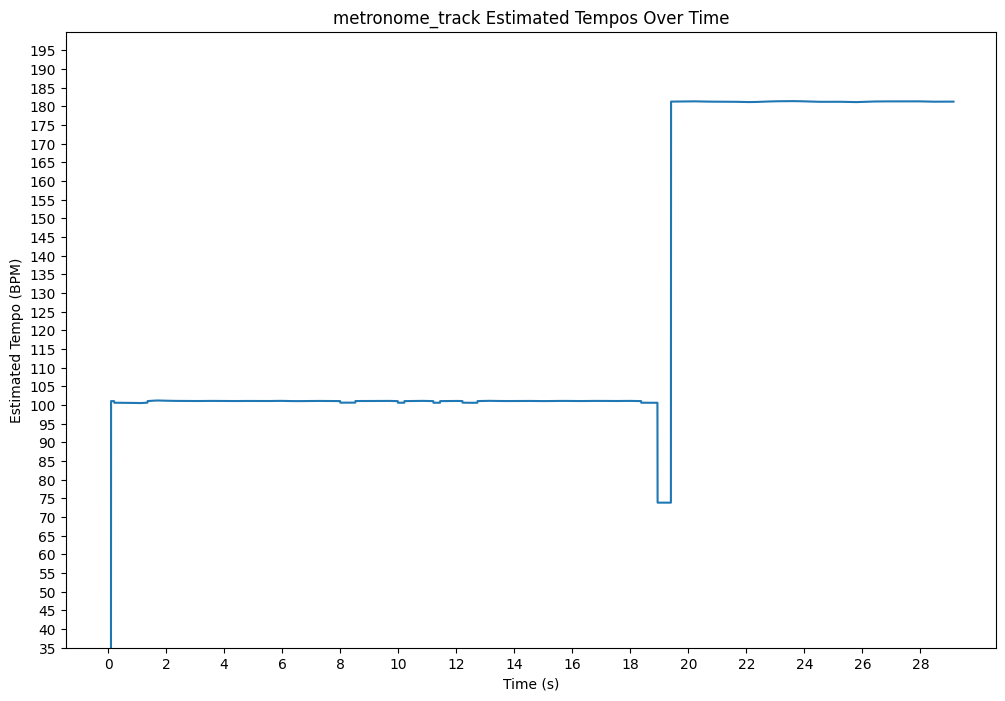

In [22]:
# extract tempos from tempogram
def extract_tempogram_tempos(tempogram, fmin, fmax, peak_threshold=0.3, window_size=5):
    half_window = window_size//2

    # find indices of fmin and fmax in tempo_bins
    fmin_idx = np.where(tempo_bins>=fmin)[0][-1]
    fmax_idx = np.where(tempo_bins<=fmax)[0][0]
    print(f'Using tempo bins in index range [{fmax_idx}, {fmin_idx}]')
    print(f'Using tempo bins in BPM range [{tempo_bins[fmin_idx]:.2f} BPM, {tempo_bins[fmax_idx]:.2f} BPM]')

    estim_tempos = []
    for i in range(tempogram.shape[1]):
        col = np.abs(tempogram[fmax_idx:fmin_idx, i])
        peak_val = np.max(col)
        peak_idx = np.argmax(col) + fmax_idx

        if peak_val > peak_threshold:
            # window around the peak
            start = max(peak_idx-half_window, fmax_idx)
            end = min(peak_idx+half_window+1, fmin_idx)
            window_idxs = np.arange(start, end)
            
            weights = np.abs(tempogram[window_idxs, i])
            if np.sum(weights) > 0: weighted_tempo = np.sum(tempo_bins[window_idxs]*weights)/np.sum(weights)
            else: weighted_tempo = tempo_bins[peak_idx]

            estim_tempos.append(float(weighted_tempo))
        elif i == 0: 
            estim_tempos.append(0)
        else: 
            estim_tempos.append(estim_tempos[i-1])
    return np.array(estim_tempos)

estim_tempos = extract_tempogram_tempos(tempogram, fmin, fmax, peak_threshold=peak_threshold)
print(f'Estimated tempos: {estim_tempos}')
tempo_t = np.arange(len(estim_tempos))*time_res

# plot estimated tempos vs time
plt.figure(figsize=(12, 8))
plt.plot(tempo_t, estim_tempos)
plt.title(f'{name} Estimated Tempos Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Estimated Tempo (BPM)')
plt.yticks(np.arange(int(fmin), int(fmax), 5))
plt.xticks(np.arange(0, tempo_t[-1], 2))
_ = plt.ylim(fmin, fmax)

In [23]:
def is_outlier(val, median, mad, threshold):
    return np.abs(val-median) > threshold*mad

def process_tempos(data, threshold=3.5, max_iter=1000):
    cleaned = data.copy()
    for _ in range(max_iter):
        median = np.median(cleaned)
        mad = np.median(np.abs(cleaned-median))
        if mad < 1e-6: break

        outlier_indices = [i for i, val in enumerate(cleaned) if is_outlier(val, median, mad, threshold)]
        if not outlier_indices: break

        for i in outlier_indices:
            if cleaned[i] > median: cleaned[i] /= 2
            elif cleaned[i] < median: cleaned[i] *= 2
    return cleaned

def remove_spikes(data, threshold=2):
    mean = np.mean(data)
    std = np.std(data)

    z_scores = (data-mean)/std
    cleaned_nan = np.copy(data)
    cleaned_nan[np.abs(z_scores)>threshold] = np.nan 

    not_nan = ~np.isnan(cleaned_nan)
    cleaned = np.interp(np.arange(len(data)), np.arange(len(data))[not_nan], cleaned_nan[not_nan])
    return cleaned

In [24]:
estim_tempos = process_tempos(estim_tempos, threshold=1)
if extra_processing:
    estim_tempos = process_tempos(estim_tempos, threshold=0.5)
    estim_tempos = remove_spikes(estim_tempos, threshold=1)

avg_tempo = np.mean(estim_tempos)
std_tempo = np.std(estim_tempos)
print(f'Average tempo: {avg_tempo:.2f} BPM')
print(f'Standard deviation: {std_tempo:.2f} BPM')

Average tempo: 127.04 BPM
Standard deviation: 39.04 BPM


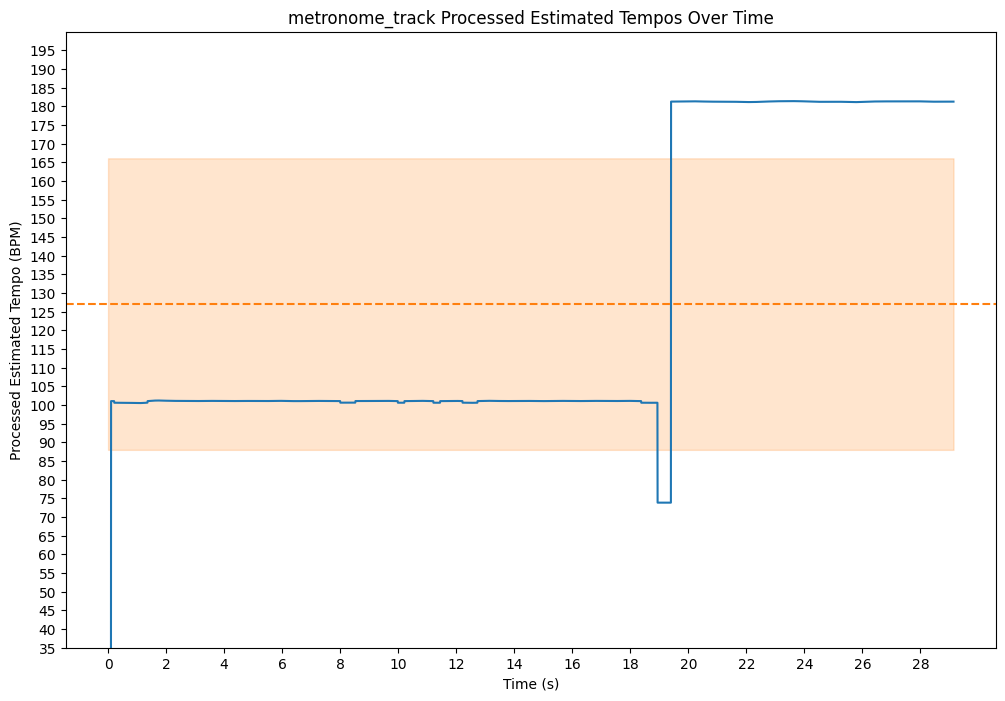

In [25]:
# plot processed estimated tempos vs time
plt.figure(figsize=(12, 8))
plt.plot(tempo_t, estim_tempos)
plt.title(f'{name} Processed Estimated Tempos Over Time')
plt.axhline(float(avg_tempo), color='#ff7f0e', linestyle='--', label=f'Avg: {avg_tempo:.2f} BPM')
plt.fill_between(tempo_t, float(avg_tempo-std_tempo), float(avg_tempo+std_tempo), alpha=0.2, color='#ff7f0e', label=f'Std: {std_tempo:.2f}')
plt.xlabel('Time (s)')
plt.ylabel('Processed Estimated Tempo (BPM)')
plt.yticks(np.arange(int(fmin), int(fmax), 5))
plt.xticks(np.arange(0, tempo_t[-1], 2))
_ = plt.ylim(fmin, fmax)

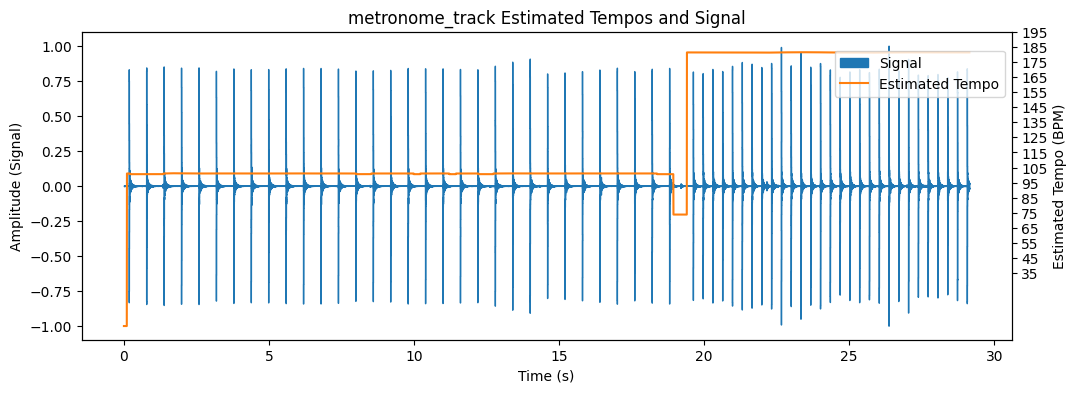

In [26]:
# plot estimated tempos and original signal
fig, ax1 = plt.subplots(figsize=(12, 4))
librosa.display.waveshow(signal, sr=sr, ax=ax1, label='Signal')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (Signal)')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(tempo_t, estim_tempos, label='Estimated Tempo', color='#ff7f0e')
ax2.set_ylabel('Estimated Tempo (BPM)')
ax2.tick_params(axis='y')
ax2.set_yticks(np.arange(int(fmin), int(fmax), 10))
plt.title(f'{name} Estimated Tempos and Signal')
_ = fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85))

In [27]:
# detect start
def detect_start(signal):
    threshold = 0.01 * np.max(np.abs(signal))
    start_idx = 0
    for i, val in enumerate(signal):
        if np.abs(val) > threshold:
            start_idx = i
            break
    return start_idx

# zero pad signal to start at signal
def zero_pad_signal(signal, start_frame):
    leading_zeros = np.argmax(signal != 0) if np.any(signal != 0) else len(signal)

    if leading_zeros < start_frame:
        pad_amount = start_frame - leading_zeros
        return np.concatenate((np.zeros(pad_amount), signal))
    elif leading_zeros > start_frame:
        return signal[(leading_zeros - start_frame):]
    else:
        return signal

In [28]:
# generate click track to verify estimated tempos
def generate_click_track_from_estimates(tempo_t, tempos, sr, duration, click_dur=50, click_freq=1000):
    click_track = np.zeros(int(sr*duration))
    click_length = int(click_dur/1000*sr)

    change_idxs = np.where(np.floor(np.abs(np.diff(tempos)))!=0)[0]
    change_idxs = np.concatenate(([0], change_idxs+1, [len(tempos)])) # always include the first index

    # start at the first time
    current_time = tempo_t[0] if len(tempo_t) > 0 else 0.0

    for seg_idx in range(len(change_idxs)-1):
        seg_start = change_idxs[seg_idx]
        seg_end = change_idxs[seg_idx+1]
        tempo = tempos[seg_start]
        if tempo <= 0:
            # skip this segment, but advance current_time to the start of next segment
            if seg_end < len(tempo_t):
                current_time = tempo_t[seg_end]
            continue
        t_start = tempo_t[seg_start]
        t_end = tempo_t[seg_end-1] if seg_end < len(tempo_t) else duration
        T = 60.0/tempo
        current_time = max(current_time, t_start) # always start placing clicks at the start of the segment
        while current_time < t_end:
            idx = int(current_time*sr)
            if idx + click_length <= len(click_track):
                click_track[idx:idx+click_length] += 0.5
            elif idx < len(click_track):
                click_track[idx:] += 0.5
            current_time += T # at the end of the segment, current_time is carried over to the next segment

    # modulate click track with sine wave
    sin_wave = np.sin(2*np.pi*click_freq*np.arange(len(click_track))/sr)
    click_track *= sin_wave

    # plot click track
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(len(click_track))/sr, click_track)
    plt.title('Click Timings')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    return click_track

Click track saved to: ../audio_out/click_metronome_track.mp3


Text(0, 0.5, 'Amplitude')

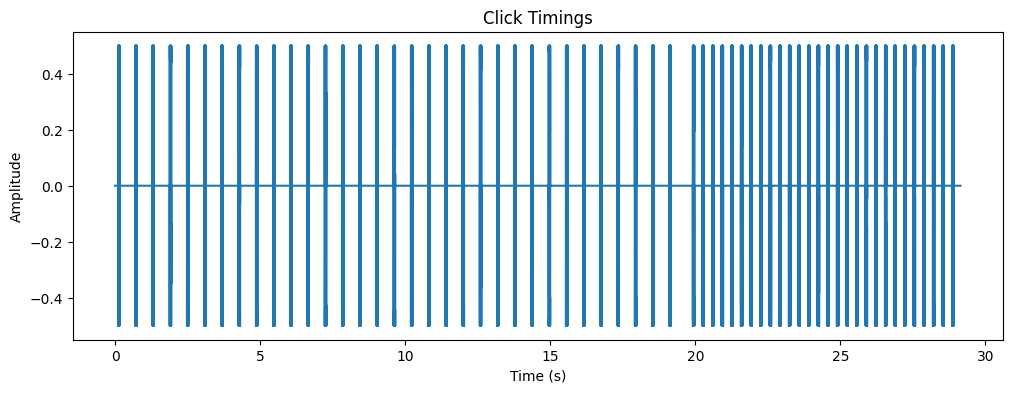

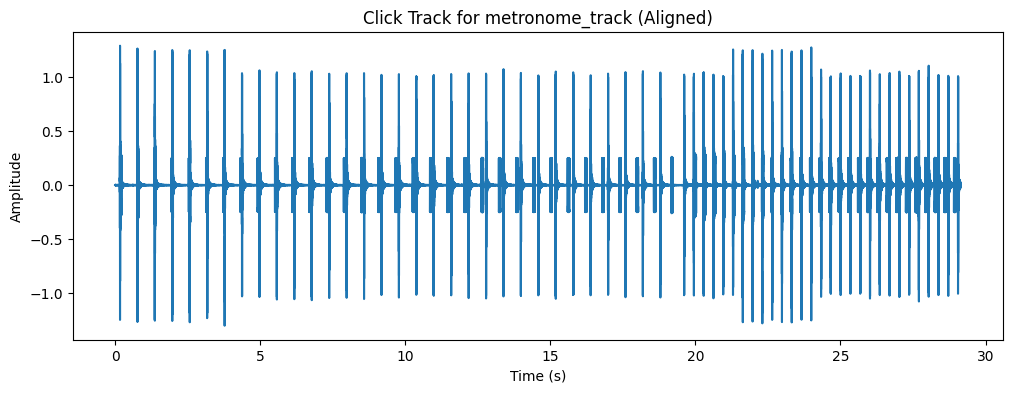

In [29]:
# align click track with first note
start_frame = detect_start(signal)
duration = len(signal)/sr
click_track = generate_click_track_from_estimates(tempo_t, estim_tempos, sr, duration)
click_track_aligned = zero_pad_signal(click_track, start_frame)

combined = None
if pedal_reduce: 
    min_len = min(len(original_signal), len(click_track_aligned))
    combined = original_signal[:min_len] + 0.5 * click_track_aligned[:min_len]
else:
    min_len = min(len(signal), len(click_track_aligned))
    combined = signal[:min_len] + 0.5 * click_track_aligned[:min_len]

# save click track to file
click_track_path = f'../audio_out/click_{name}.mp3'
sf.write(click_track_path, combined, sr)
print(f'Click track saved to: {click_track_path}')

# plot click track
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(combined))/sr, combined)
plt.title(f'Click Track for {name} (Aligned)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

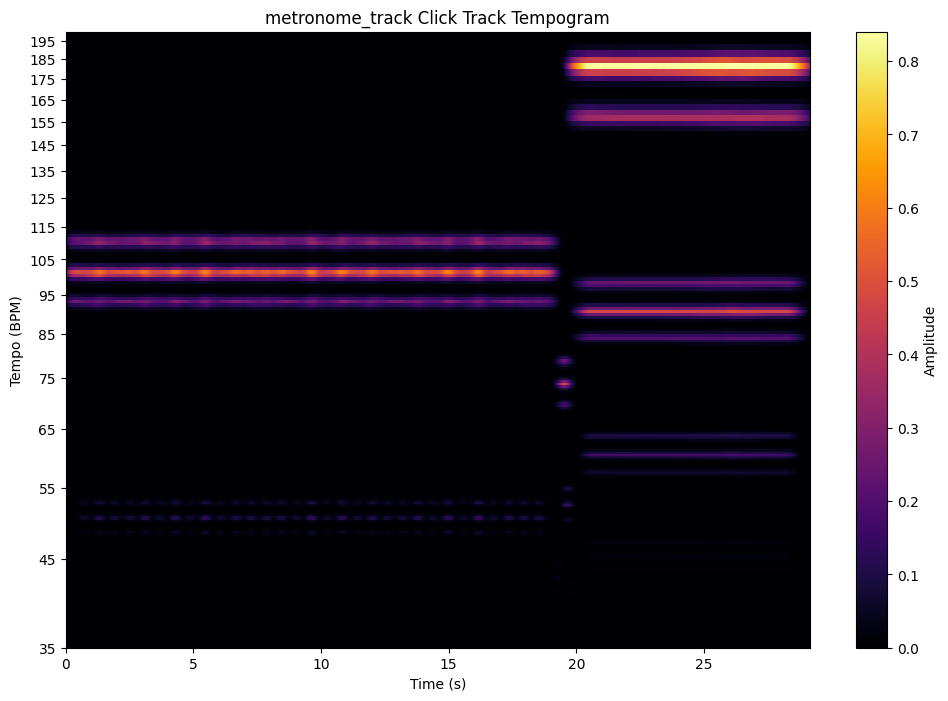

In [30]:
click_onset_env = librosa.onset.onset_strength(y=click_track, sr=sr, hop_length=hop_length)
click_tempogram = librosa.feature.tempogram(onset_envelope=click_onset_env, sr=sr, hop_length=hop_length, win_length=win_length)[1:,:]

# plot tempogram of the click track
plt.figure(figsize=(12, 8))
librosa.display.specshow(click_tempogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='tempo', cmap='inferno')
plt.ylim(fmin, fmax)
plt.colorbar(label='Amplitude')
plt.title(f'{name} Click Track Tempogram')
plt.xlabel('Time (s)')
plt.ylabel('Tempo (BPM)')
_ = plt.yticks(yticks)

Using tempo bins in index range [52, 295]
Using tempo bins in BPM range [35.04 BPM, 198.77 BPM]


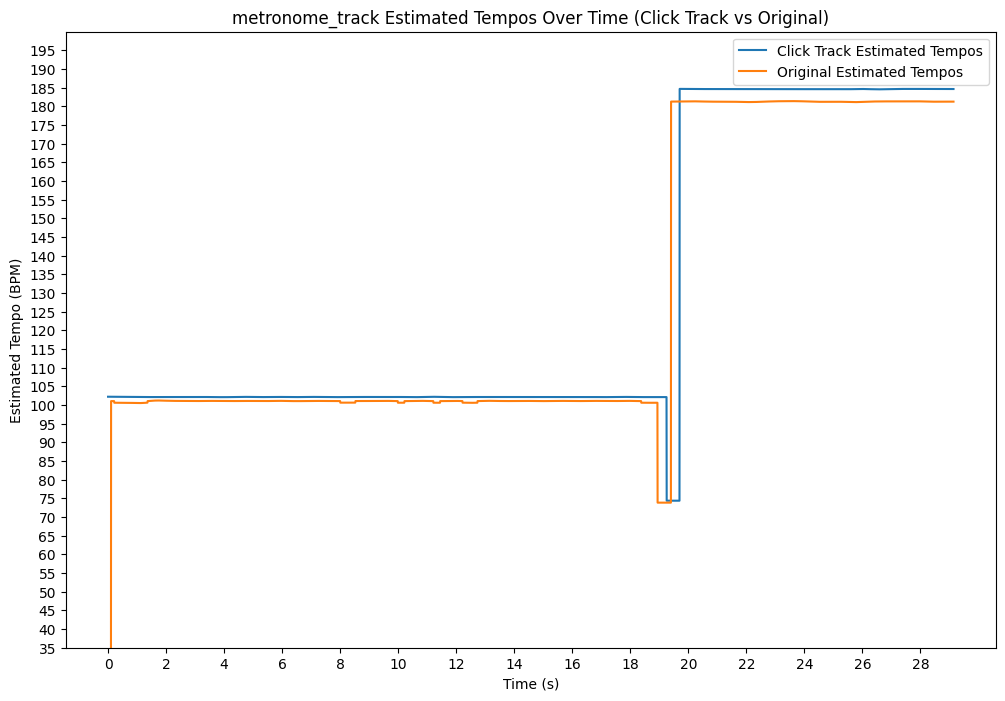

In [31]:
cleaned_estim_tempos = extract_tempogram_tempos(click_tempogram, fmin, fmax, peak_threshold=peak_threshold)
cleaned_tempo_t = np.arange(len(cleaned_estim_tempos))*time_res

# plot cleaned_estim_tempos and estim_tempos vs time
plt.figure(figsize=(12, 8))
plt.plot(cleaned_tempo_t, cleaned_estim_tempos, label='Click Track Estimated Tempos')
plt.plot(tempo_t, estim_tempos, label='Original Estimated Tempos')
plt.title(f'{name} Estimated Tempos Over Time (Click Track vs Original)')
plt.xlabel('Time (s)')
plt.ylabel('Estimated Tempo (BPM)')
plt.yticks(np.arange(int(fmin), int(fmax), 5))
plt.xticks(np.arange(0, tempo_t[-1], 2))
plt.ylim(fmin, fmax)
plt.legend()